In [1]:
# Standard libraries
import os
import warnings
import sys
sys.path.append(os.path.abspath("../"))  # subir un nivel y entrar en src


# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx.convert_matrix import to_pandas_adjacency


In [4]:
# Custom modules
from netbayesabm.classes import Environment_plant, Environment_pol
from netbayesabm.data_analysis import area_plot
from netbayesabm.modelling import (
    initial_network,
    update_totalinks,
    remove_zero,
    degree_dist,
    initial_pollinators_random,
)
from netbayesabm.visualization import plot_abundances, plot_priors
#import nxproperties as nxp

# Ignore all warnings (use with caution)
warnings.filterwarnings('ignore')


In [5]:
# Directory where output files will be saved
output_dir = "Output_analysis"
os.makedirs(output_dir, exist_ok=True)

In [6]:
# --- Simulation parameters ---

# Number of draws from the prior distribution
n_draws = 100

# Plot and time slice selection
selected_plot = 'A'
slice_index = 3
interaction_scale = 5  # Number of pollinators per plant

# Construct the output filename
output_filename = f"{selected_plot}{slice_index}_nd{n_draws}"


In [7]:
# --- Load interaction network for the selected plot and slice ---

network_path = f"Data/network_plot_{selected_plot}_slice_{slice_index}.csv"
df_net = pd.read_csv(network_path, sep=';')
df_net.head()

,Plant_id,Acmaeodera_sp,Anthrenus_sp,Attagenus_sp,Bombylius_sp,Buprestidae_sp1,Ceratina_sp,Chasmatopterus_sp,Coptocephala_sp,Curculionidae,...,Oedemera_sp,Paragus_tibialis,Phthiria_sp1,Phthiria_sp2,Plebejus_argus,Rhyzobius_lophanthae,Tiphia_morio,Tychius_sp,Usia_sp,Xylocopa_cantabrita
0,471,0.000000,0.0,0.0,0.0,0.0,0.0,1.387507,0.0,0.000000,...,0.0,0.0,0.001156,0.000000,0.0,0.0,0.0,0.0,0.001156,0.0
1,472,0.000000,0.0,0.0,0.0,0.0,0.0,1.414657,0.0,0.000000,...,0.0,0.0,0.000621,0.000621,0.0,0.0,0.0,0.0,0.000000,0.0
2,473,0.001054,0.0,0.0,0.0,0.0,0.0,1.212193,0.0,0.000527,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,474,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.390910,0.0,0.0,0.0,0.0,0.000000,0.0
4,475,0.000000,0.0,0.0,0.0,0.0,0.0,0.542555,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [8]:
# Extract plant IDs as strings
plant_list = df_net["Plant_id"].astype(str).tolist()

# --- Load plant coordinates and filter for current plant list ---

df_plant = pd.read_csv("Data/coords_plot_month.csv", sep=';')
df_plant_pm = df_plant.query("Plant_id in @plant_list").drop_duplicates(subset="Plant_id")

# --- Load total number of visits for the selected plot and slice ---

df_visit = pd.read_csv("Data/n_visits_slice_plot.csv", sep=';')
nt_links = df_visit.query("Slice == @slice_index and Plot == @selected_plot")["Frequency"].values[0]


In [9]:
# --- Calculate spatial boundaries from plant data ---
xmin, ymin, xmax, ymax = area_plot(df_plant_pm)


In [10]:
# --- Initialize plant environment ---
# Creates plant agents with spatial positions (randomly distributed within bounds),
# species identity, and unique IDs

# --- Initialize plant environment ---
# Three options available:
#
# 1) Default: use coordinates from DataFrame
#    envp = Environment_plant(df_plant_pm)
#
# 2) Random: assign coordinates uniformly within bounds
#    envp = Environment_plant(df_plant_pm, random_position=True,
#                             xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
#
# 3) Regular: assign coordinates on a grid within bounds
#    envp = Environment_plant(df_plant_pm, regular_position=True,
#                             xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

envp = Environment_plant(
    df_plant_pm,
    random_position=True,
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax
)


In [11]:
# --- Initialize plant environment ---

# Option 1: Use coordinates from DataFrame
envp_default = Environment_plant(df_plant_pm)

# Option 2: Assign random coordinates within bounds
envp_random = Environment_plant(
    df_plant_pm.copy(),  # use a copy to avoid overwriting
    random_position=True,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax
)

# Option 3: Assign regular grid coordinates within bounds
envp_regular = Environment_plant(
    df_plant_pm.copy(),
    regular_position=True,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax
)

In [12]:
# Number of plant agents
n_plants = len(envp.plant_list)

# Number of pollinator agents (based on scale)
n_pollinators = interaction_scale * n_plants


In [13]:
# --- Compute relative abundances of pollinator species ---

# Proportional abundance per species (excluding the first column, assumed to be Plant_id)
dist_pol = df_net.iloc[:, 1:].sum()
dist_pol = dist_pol / dist_pol.sum()
dist_pol = np.round(dist_pol, decimals=4)

# Sort species by abundance to ensure last adjustment is on the largest value
dist_pol = dist_pol.sort_values()

# Adjust final value to ensure exact sum to 1 (fix for rounding error)
dist_pol.iloc[-1] += (1.0 - dist_pol.sum())

# --- Count number of unique species ---

n_plant_species = df_plant_pm["Plant_sp_complete"].nunique()
n_pollinator_species = len(dist_pol.index)

# --- Report summary statistics ---

print(f"Number of plant agents: {n_plants}")
print(f"Number of pollinator agents: {n_pollinators}")
print(f"Number of plant species: {n_plant_species}")
print(f"Number of pollinator species: {n_pollinator_species}")

Number of plant agents: 27
Number of pollinator agents: 135
Number of plant species: 3
Number of pollinator species: 28


In [14]:
# --- Save pollinator abundance distribution ---

dist_pol_path = os.path.join(output_dir, f"{output_filename}_species_dist_pol_model2.csv")
dist_pol.to_csv(dist_pol_path)


<Axes: title={'center': 'A3_nd100'}, xlabel='P(Abundances)', ylabel='Number of Species'>

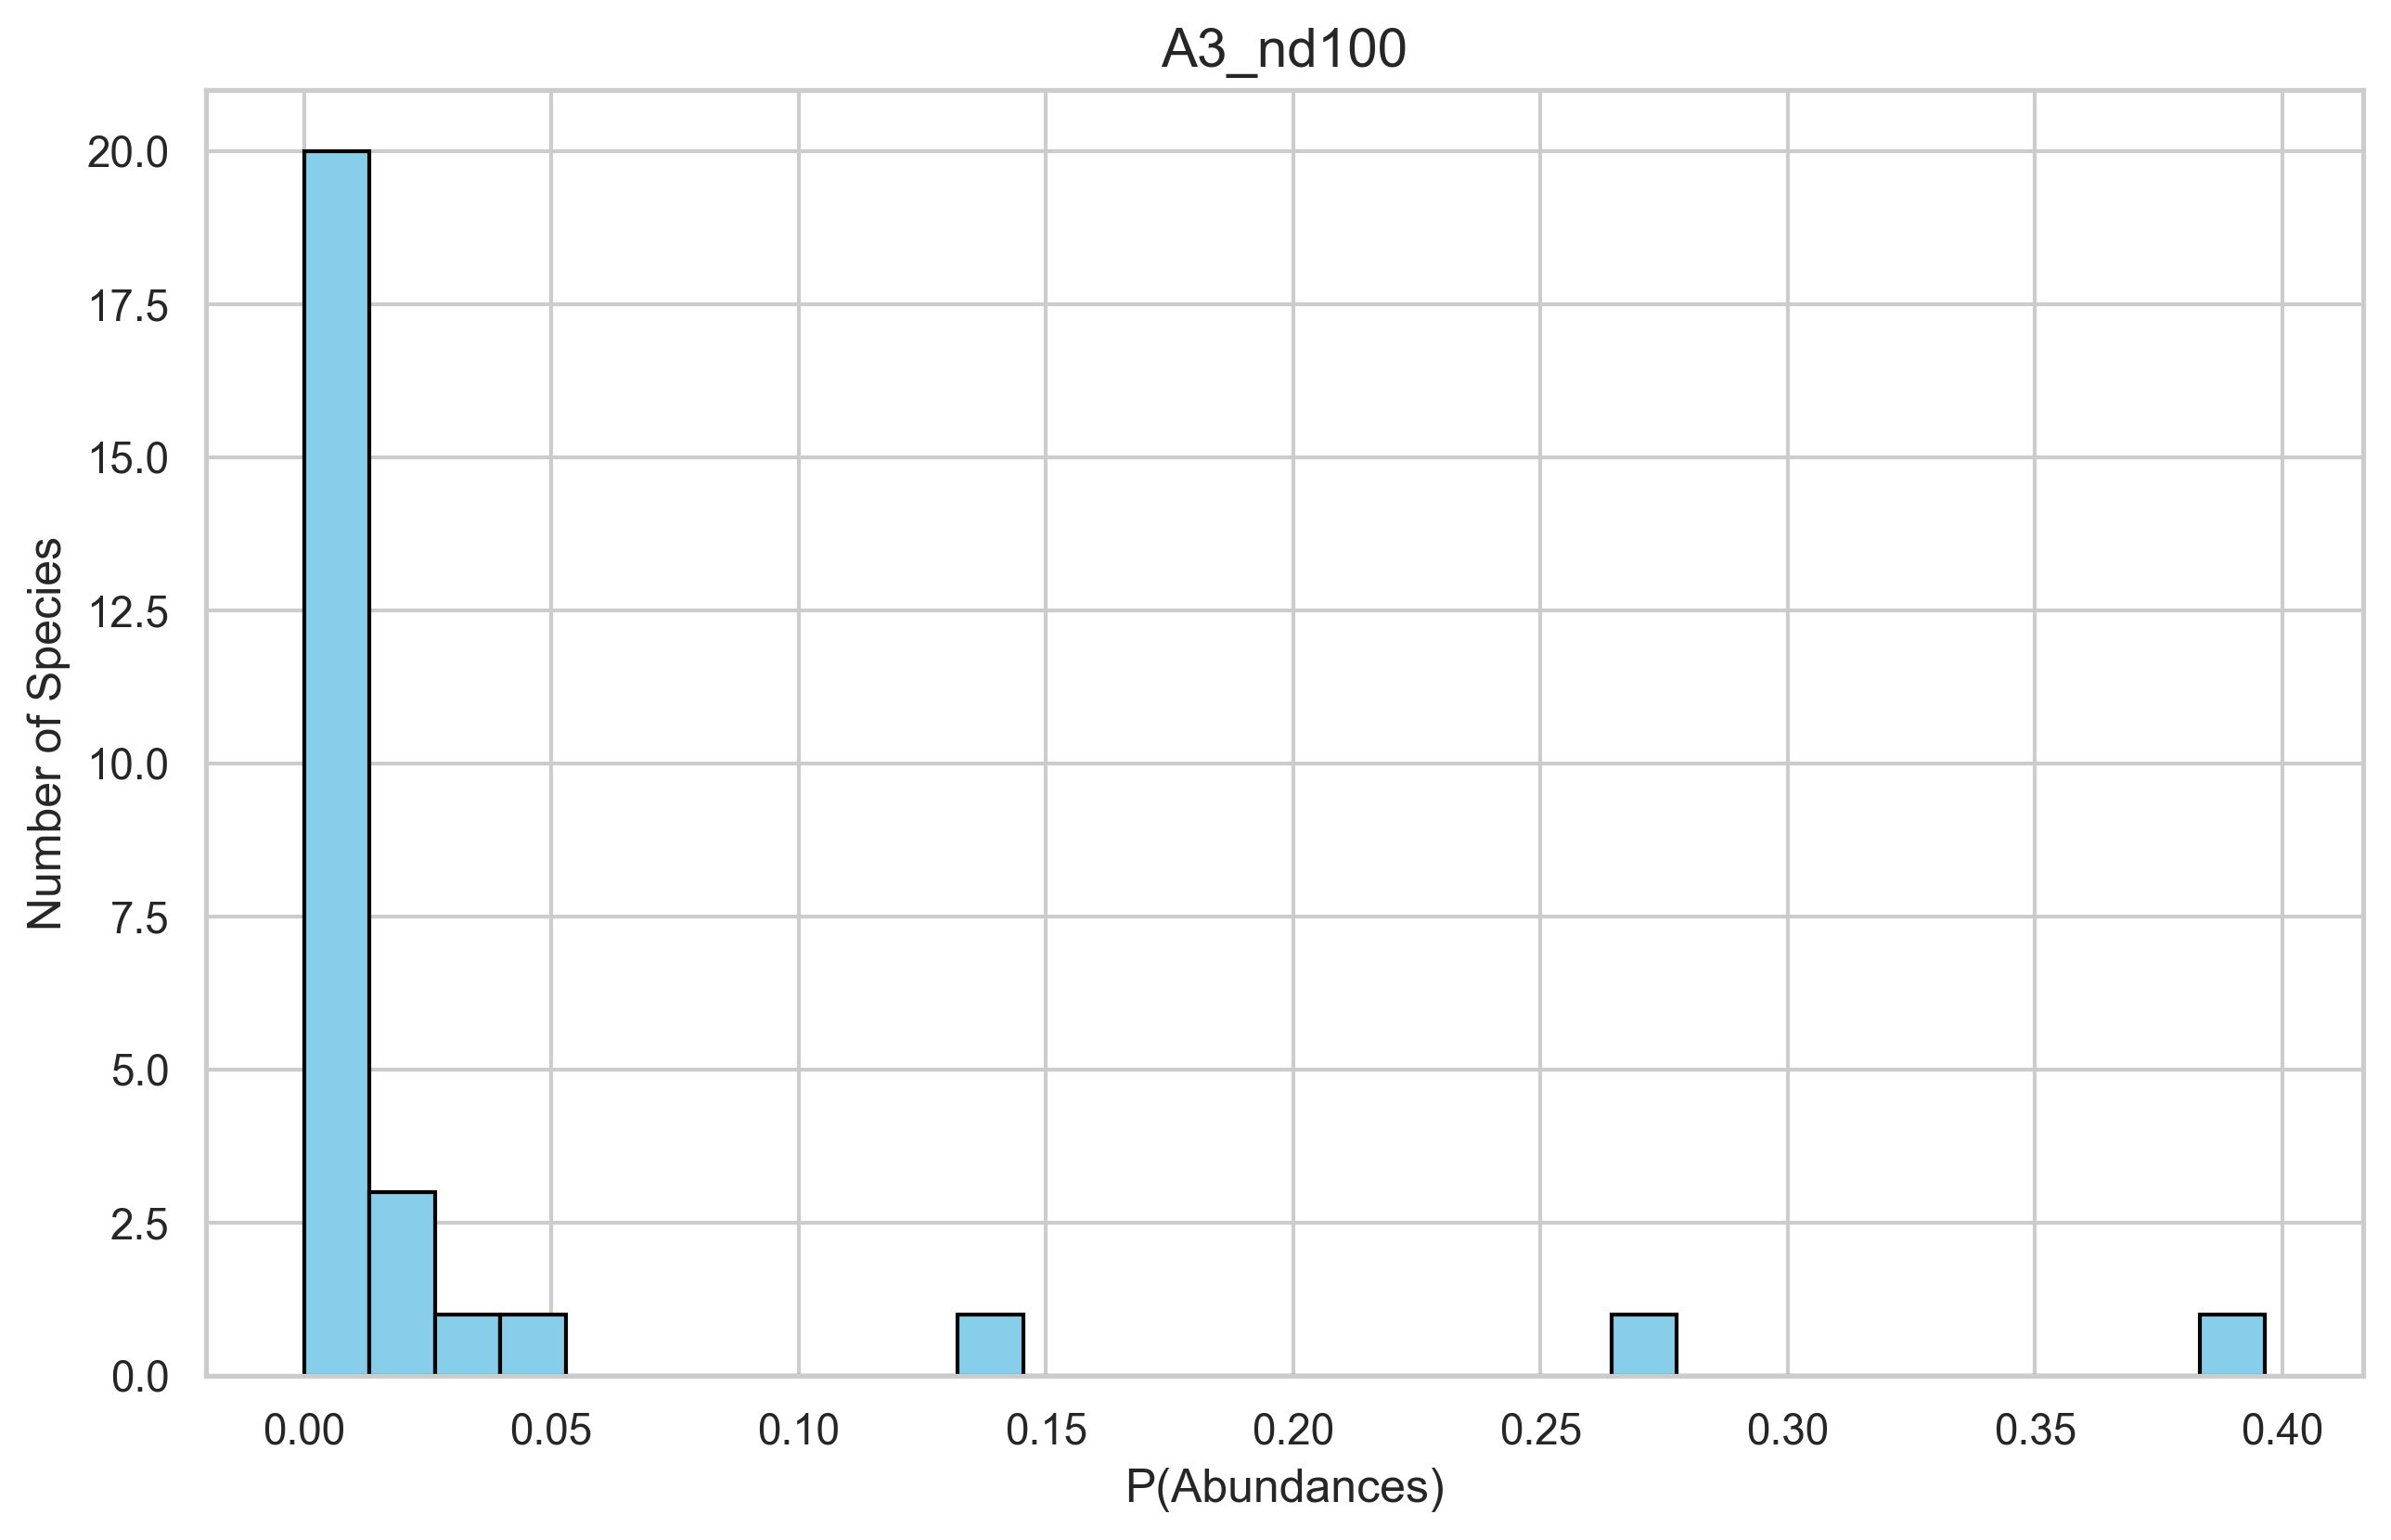

In [15]:
# Plot and save species abundance distribution
plot_abundances(dist_pol, output_filename, save=True)


In [16]:
# Generate priors (r distributions for specialists and generalists) ---

# Parameters for gamma distributions
shape_specialist = 2
shape_generalist = 5
scale_specialist = 2
scale_generalist = 1

# Name suffix for saving prior plots or files
prior_name = f"_gamma_s{shape_specialist}_{shape_generalist}_sc{scale_specialist}_{scale_generalist}"


In [17]:
# Generate gamma-distributed priors
prior_specialist = pd.Series(np.random.gamma(shape_specialist, scale_specialist, size=n_draws))
prior_generalist = pd.Series(np.random.gamma(shape_generalist, scale_generalist, size=n_draws))

# ---- Option B: Exponential distributions (alternative) ----
# exp_specialist = 10
# exp_generalist = 20
# prior_name = f"_exp_s{exp_specialist}_{exp_generalist}"
# prior_specialist = pd.Series(np.random.exponential(scale=exp_specialist, size=n_draws))
# prior_generalist = pd.Series(np.random.exponential(scale=exp_generalist, size=n_draws))


# Optional: plot prior distributions
# plot_priors(prior_specialist, prior_generalist, prior_name)

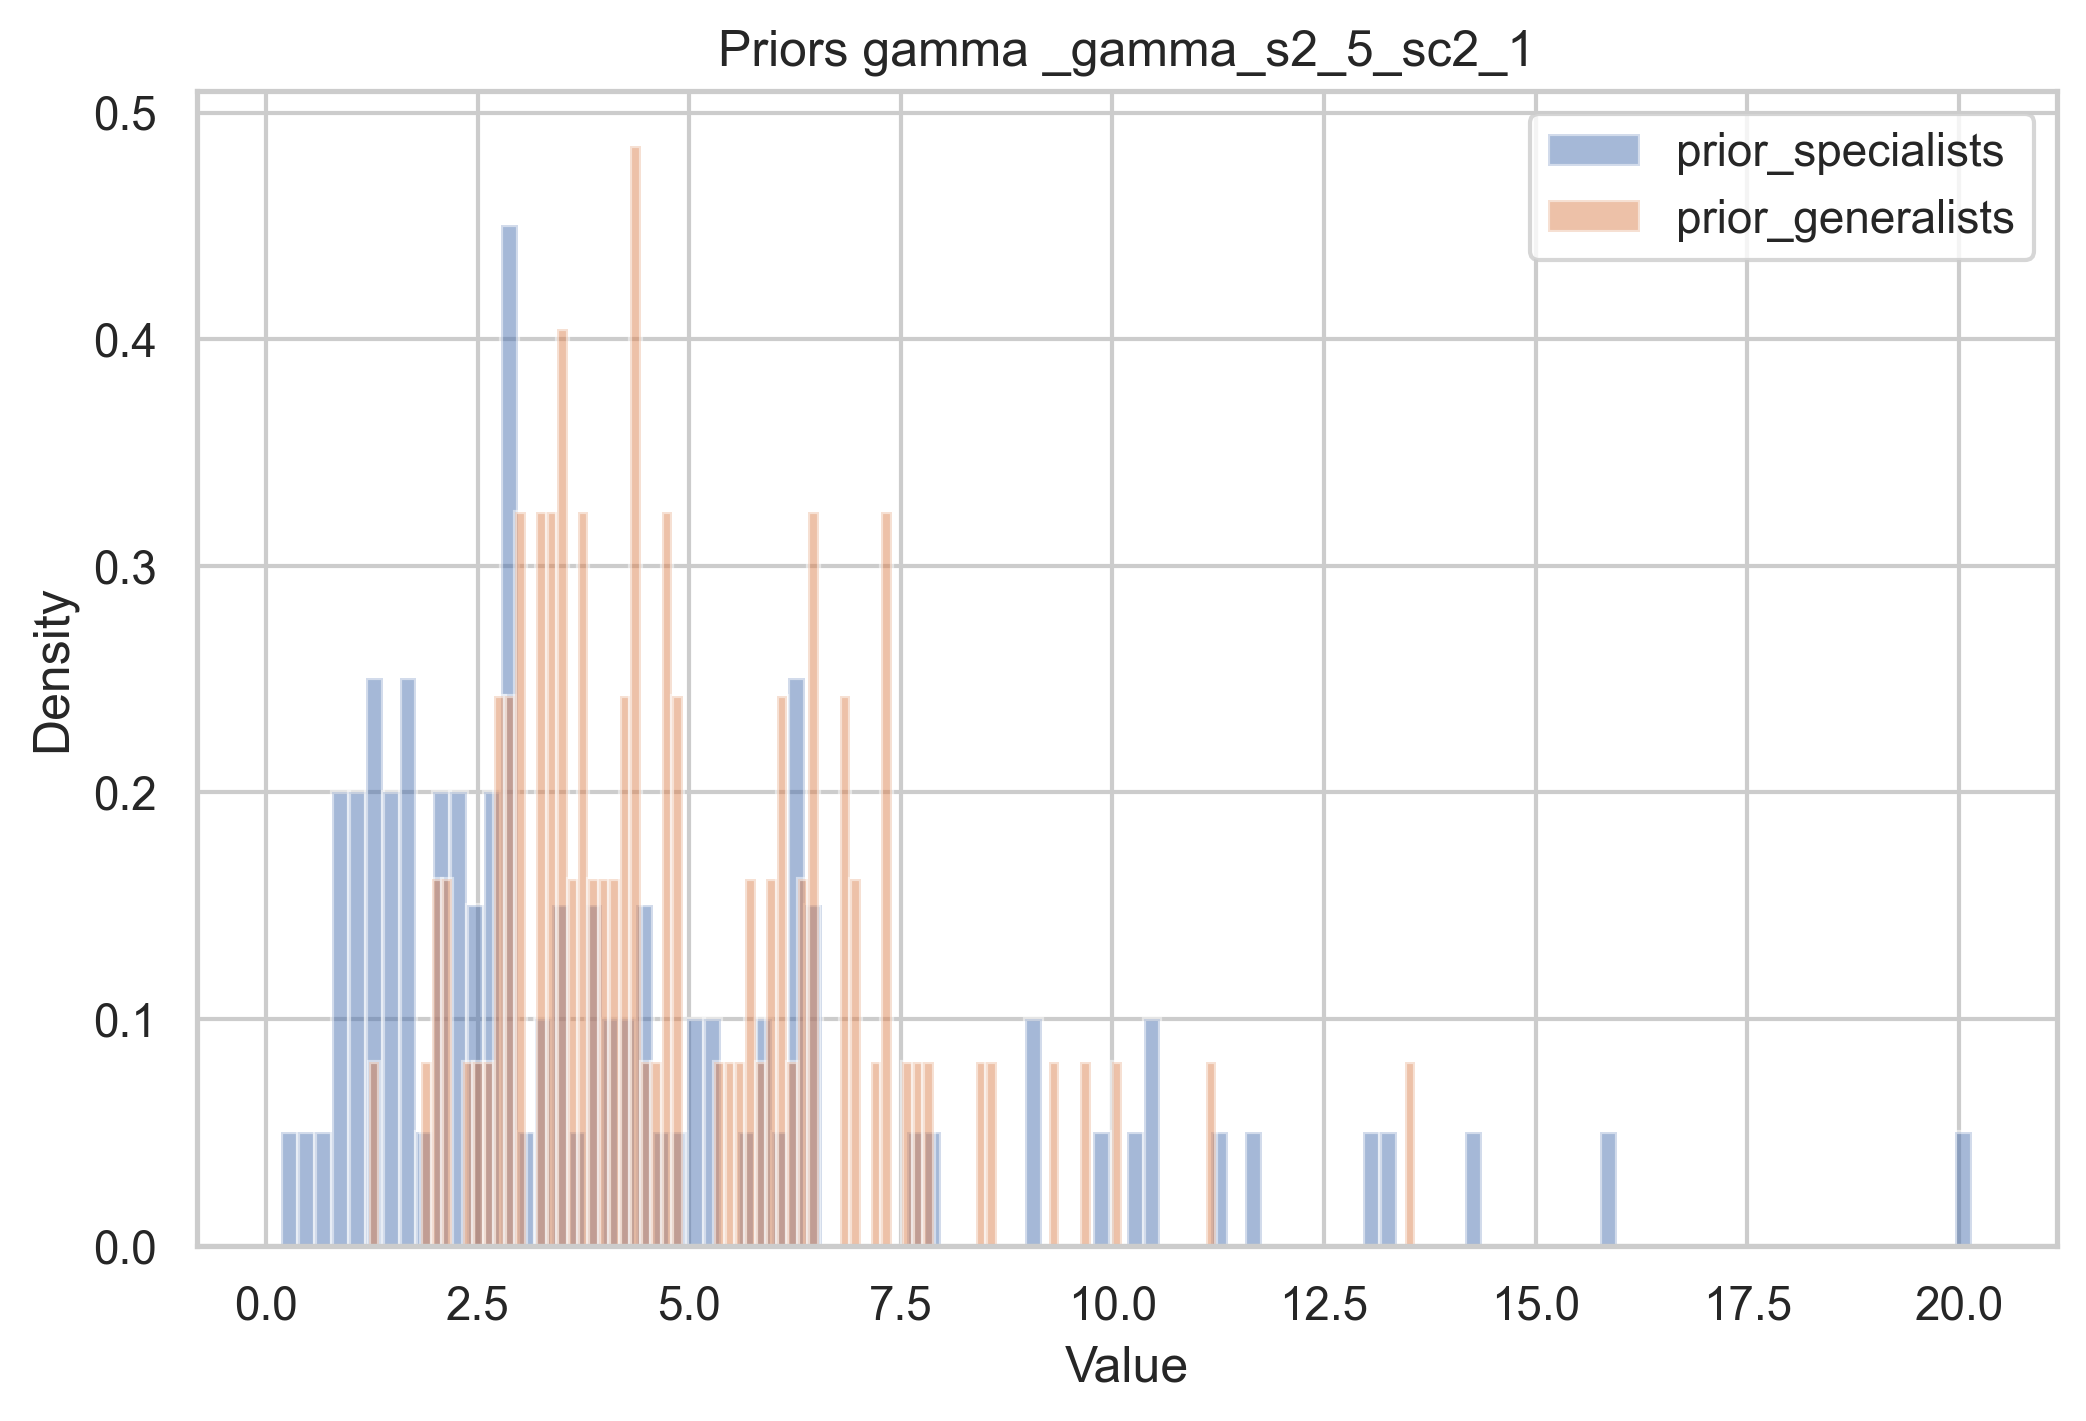

In [18]:
# Plot prior distributions
plot_priors(prior_specialist, prior_generalist, prior_name, save=True)

# Option to save ABM matrices for each iteration
save_abm_matrices = False  # Set to True to enable saving


In [19]:
# Run simulation over multiple draws ---

all_deg_pol = pd.DataFrame()
all_deg_pla = pd.DataFrame()




In [20]:
for i in range(n_draws):
    
    # Generate initial pollinators with random distribution
    generalists, df_polPM = initial_pollinators_random(
        dist_pol, n_pollinators,
        xmin, xmax, ymin, ymax
    )
    
    #generalistas,df_polPM = initial_pollinators(dist_pol, n_pollinators, xmin, xmax, ymin, ymax)
    #generalistas,df_polPM = initial_pollinators_random(dist_pol, n_pollinators, xmin, xmax, ymin, ymax,random_distribution=True)

    # Assign interaction radius from prior (same for both types here)
    df_polPM.loc[df_polPM['Tipo'] == 'Especialista', 'Radius'] = prior_specialist[i]
    df_polPM.loc[df_polPM['Tipo'] == 'Generalista', 'Radius'] = prior_specialist[i]
    #df_polPM.loc[df_polPM['Tipo'] == 'Generalista', 'Radius'] = prior_generalist[i]

    # Initialize pollinator environment
    envpol = Environment_pol(df_polPM)

    # Create initial bipartite network (pollinator × plant)
    B = initial_network(df_polPM['Pol_id'].tolist(), df_plant_pm['Plant_id'].tolist())

    # Assign interactions based on distance constraints
    update_totalinks(nt_links, envpol, envp, B, xmin, xmax, ymin, ymax)

    # Remove agents with no links
    remove_zero(B)

    # Extract plant-pollinator submatrix
    B_df = to_pandas_adjacency(B)
    df_ABM = B_df.iloc[:-len(df_plant_pm), len(df_polPM):]  # [pollinators, plants]

    # Annotate ABM matrix with species
    df_ABM['Sp_pol'] = df_ABM.index.map(df_polPM.set_index('Pol_id')['Specie'])
    df_ABM.loc['Sp_plant'] = df_ABM.columns.map(df_plant_pm.set_index('Plant_id')['Plant_sp'])

    # Optionally save ABM matrix for this iteration
    if save_abm_matrices:
        abm_path = os.path.join(output_dir, f"{i}_{output_filename}_{prior_name}_ABM.csv")
        df_ABM.to_csv(abm_path)

    # Aggregate pollinator links by species
    df_species = df_ABM.groupby('Sp_pol').sum()

    # Transpose to get plant × pollinator species matrix (model)
    df_model = df_species.T

    # Real interaction matrix (based on input network)
    df_real = df_net.set_index('Plant_id')

    # --- Degree distributions ---

    pol_d_model, plant_d_model = degree_dist(df_model)
    pol_d_real, plant_d_real = degree_dist(df_real)

    # Merge plant degree distributions
    plant_d_model.index = plant_d_model.index.map(str)
    plant_d_real.index = plant_d_real.index.map(str)
    index_union = plant_d_real.index.union(plant_d_model.index)

    deg_plant = pd.DataFrame(index=index_union)
    deg_plant['Model'] = plant_d_model
    deg_plant['Real'] = plant_d_real
    deg_plant = deg_plant.fillna(0)

    # Merge pollinator degree distributions
    deg_pol = pd.concat([pol_d_model, pol_d_real], axis=1, keys=['Model', 'Real'])
    deg_pol = deg_pol.fillna(0)

    # Add metadata
    deg_pol['iteration'] = i
    deg_plant['iteration'] = i
    deg_pol['r_esp'] = prior_specialist[i]
    deg_pol['r_gen'] = prior_specialist[i]
    #deg_pol['r_gen'] = prior_generalist[i]

    #box_plot_comp(deg_pol, deg_pla, 'Degree')
    #KDE_plot_comp(deg_pol, deg_pla, 'Degree')

    # Add pollinator type
    deg_pol['Tipo'] = deg_pol.index.map(lambda j: 'Generalista' if j in generalists else 'Especialista')

    # Accumulate results
    all_deg_pol = pd.concat([all_deg_pol, deg_pol])
    all_deg_pla = pd.concat([all_deg_pla, deg_plant])

In [21]:
# --- Save aggregated degree distributions ---

deg_pol_path = os.path.join(output_dir, f"{output_filename}_{prior_name}_species_deg_pol_model2.csv")
deg_pla_path = os.path.join(output_dir, f"{output_filename}_{prior_name}_species_deg_pla_model2.csv")

all_deg_pol.to_csv(deg_pol_path)
all_deg_pla.to_csv(deg_pla_path)

### Visualization of the initial positions of agents

In this section we show how **plants** and **pollinators** are spatially distributed at the start of the simulation.  

Depending on how the environment (`Environment_plant`) is initialized, plants can be:
- At the coordinates provided in the original *DataFrame*.
- Distributed **randomly** within the defined spatial boundaries.
- Arranged on a **regular grid** within the boundaries.

Pollinators, on the other hand, are initialized according to the abundance distributions defined in the model.  

The following plot shows the initial locations of both groups of agents.

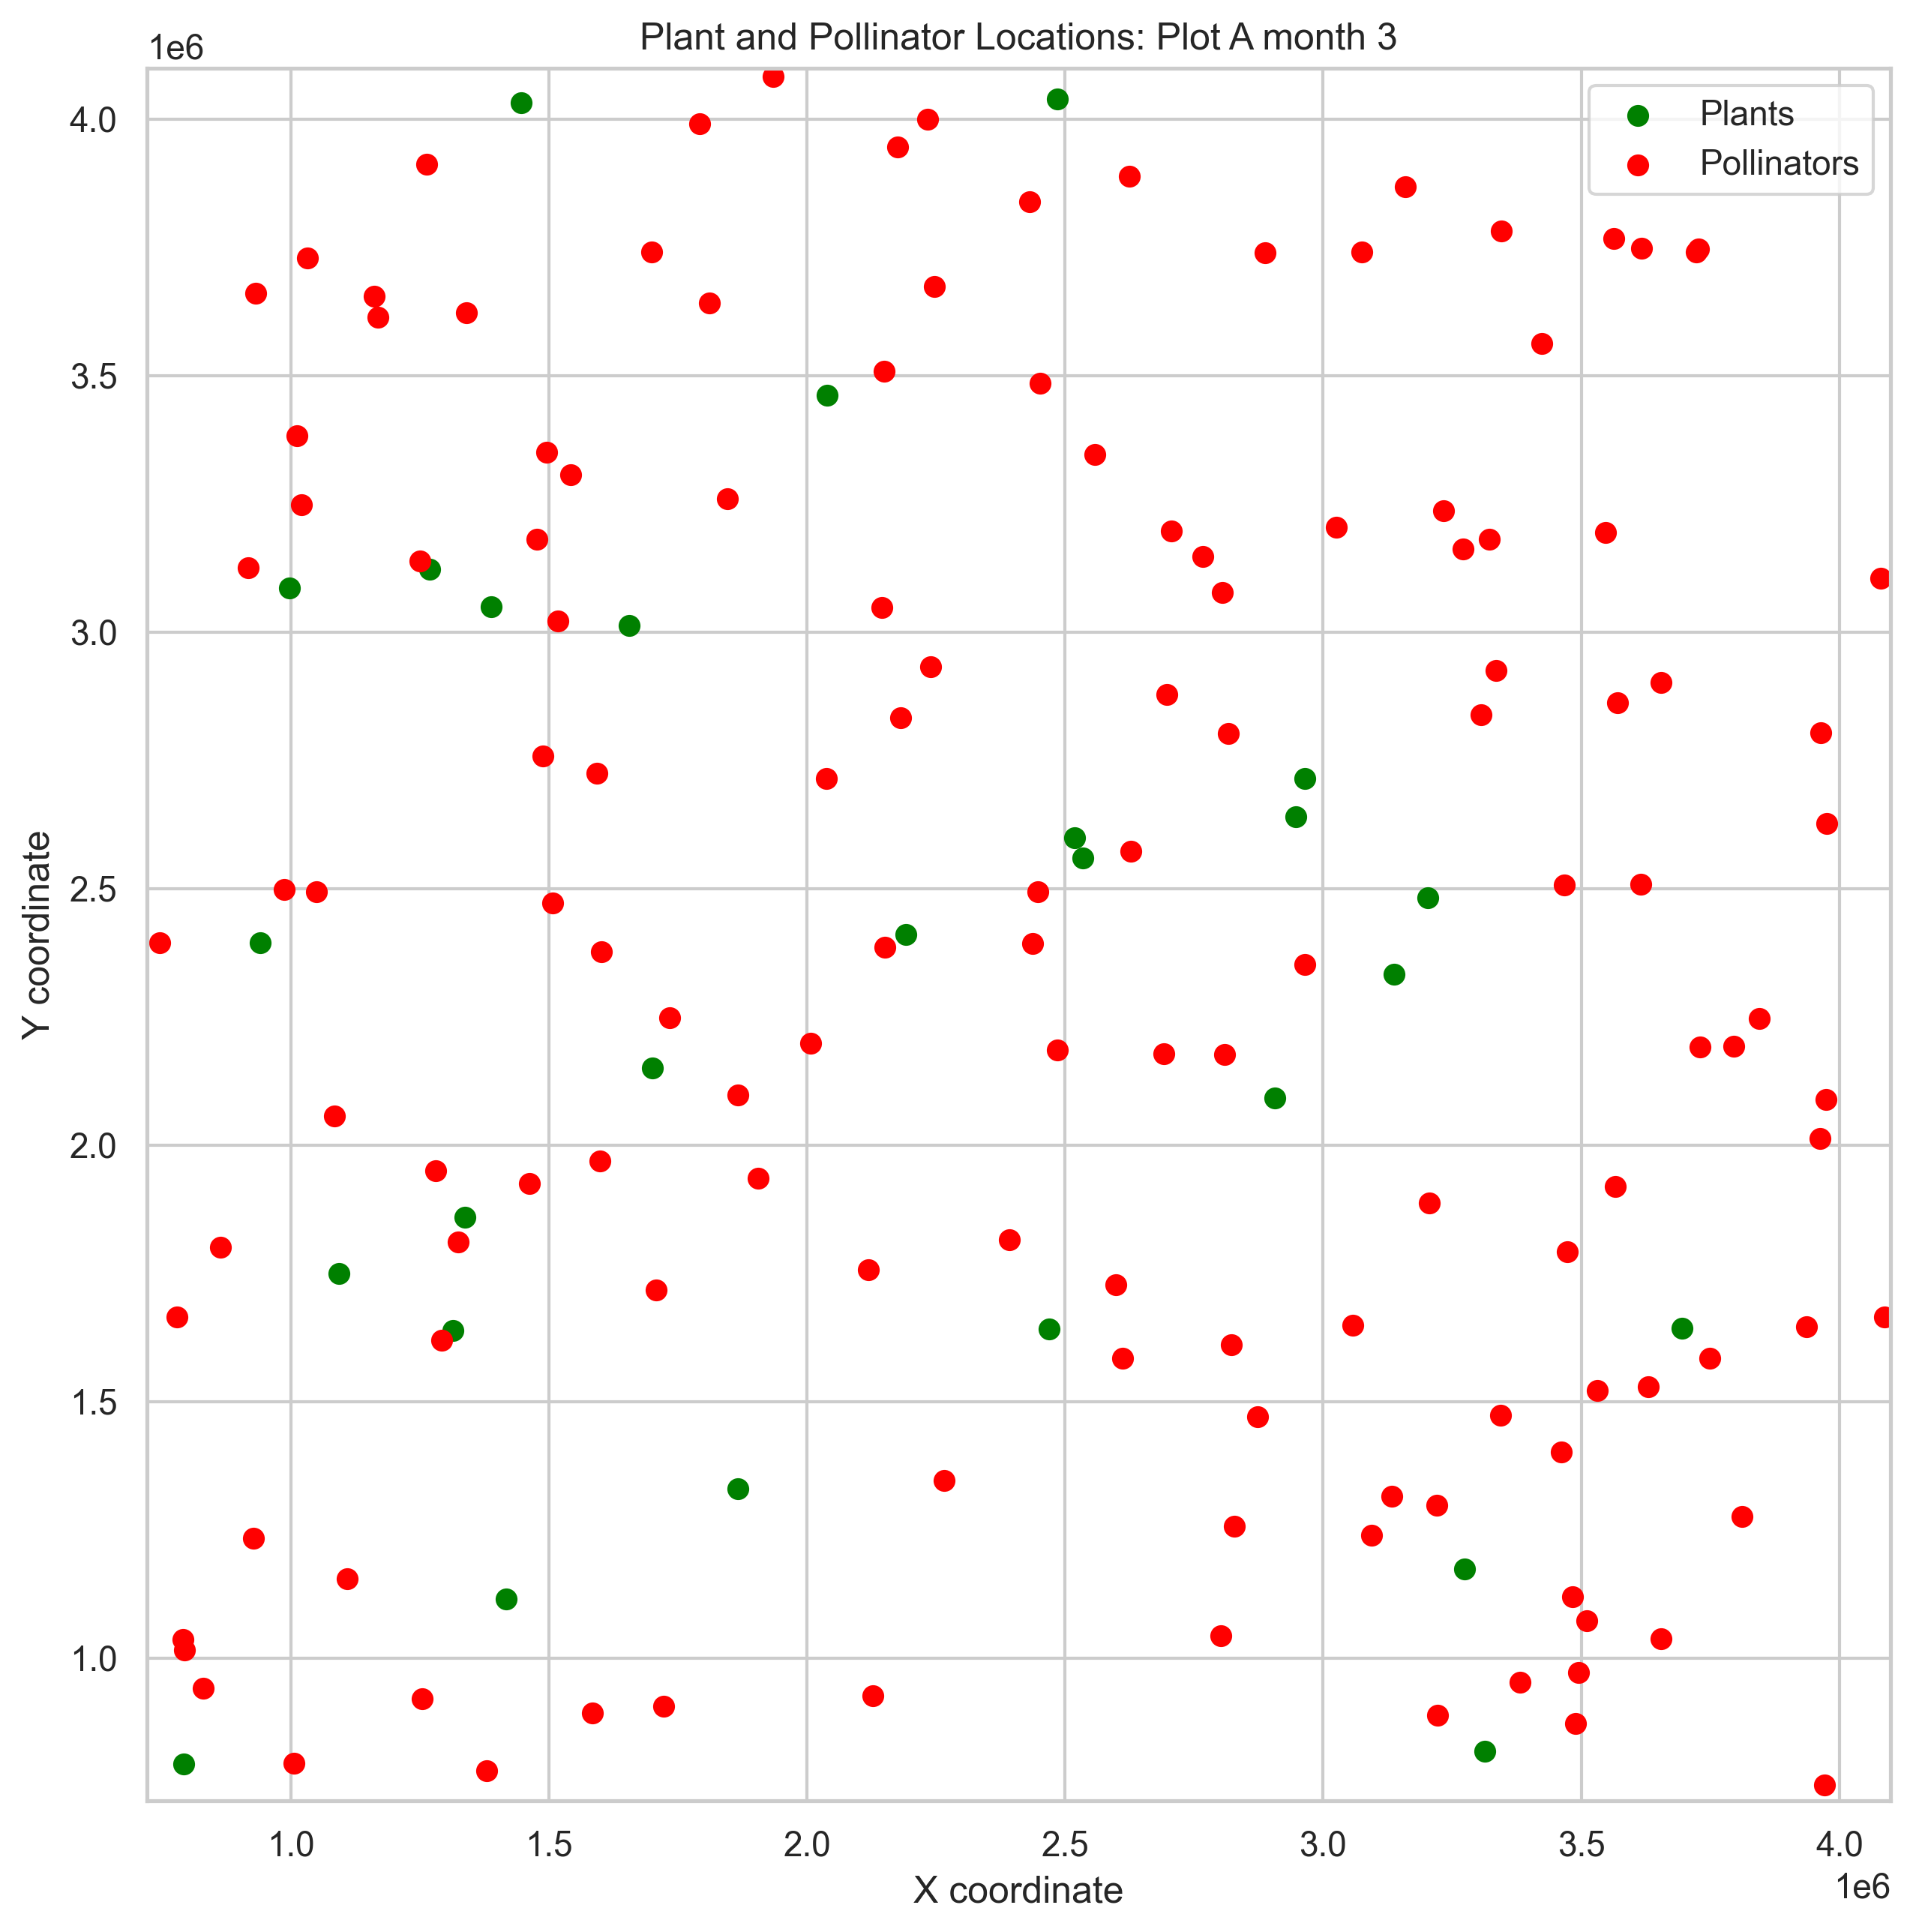

In [22]:
from netbayesabm.visualization import plot_agents

# 1. Visualize initial agent positions
ax = plot_agents(envp, envpol, selected_plot, slice_index, xmin, xmax, ymin, ymax, save=False)


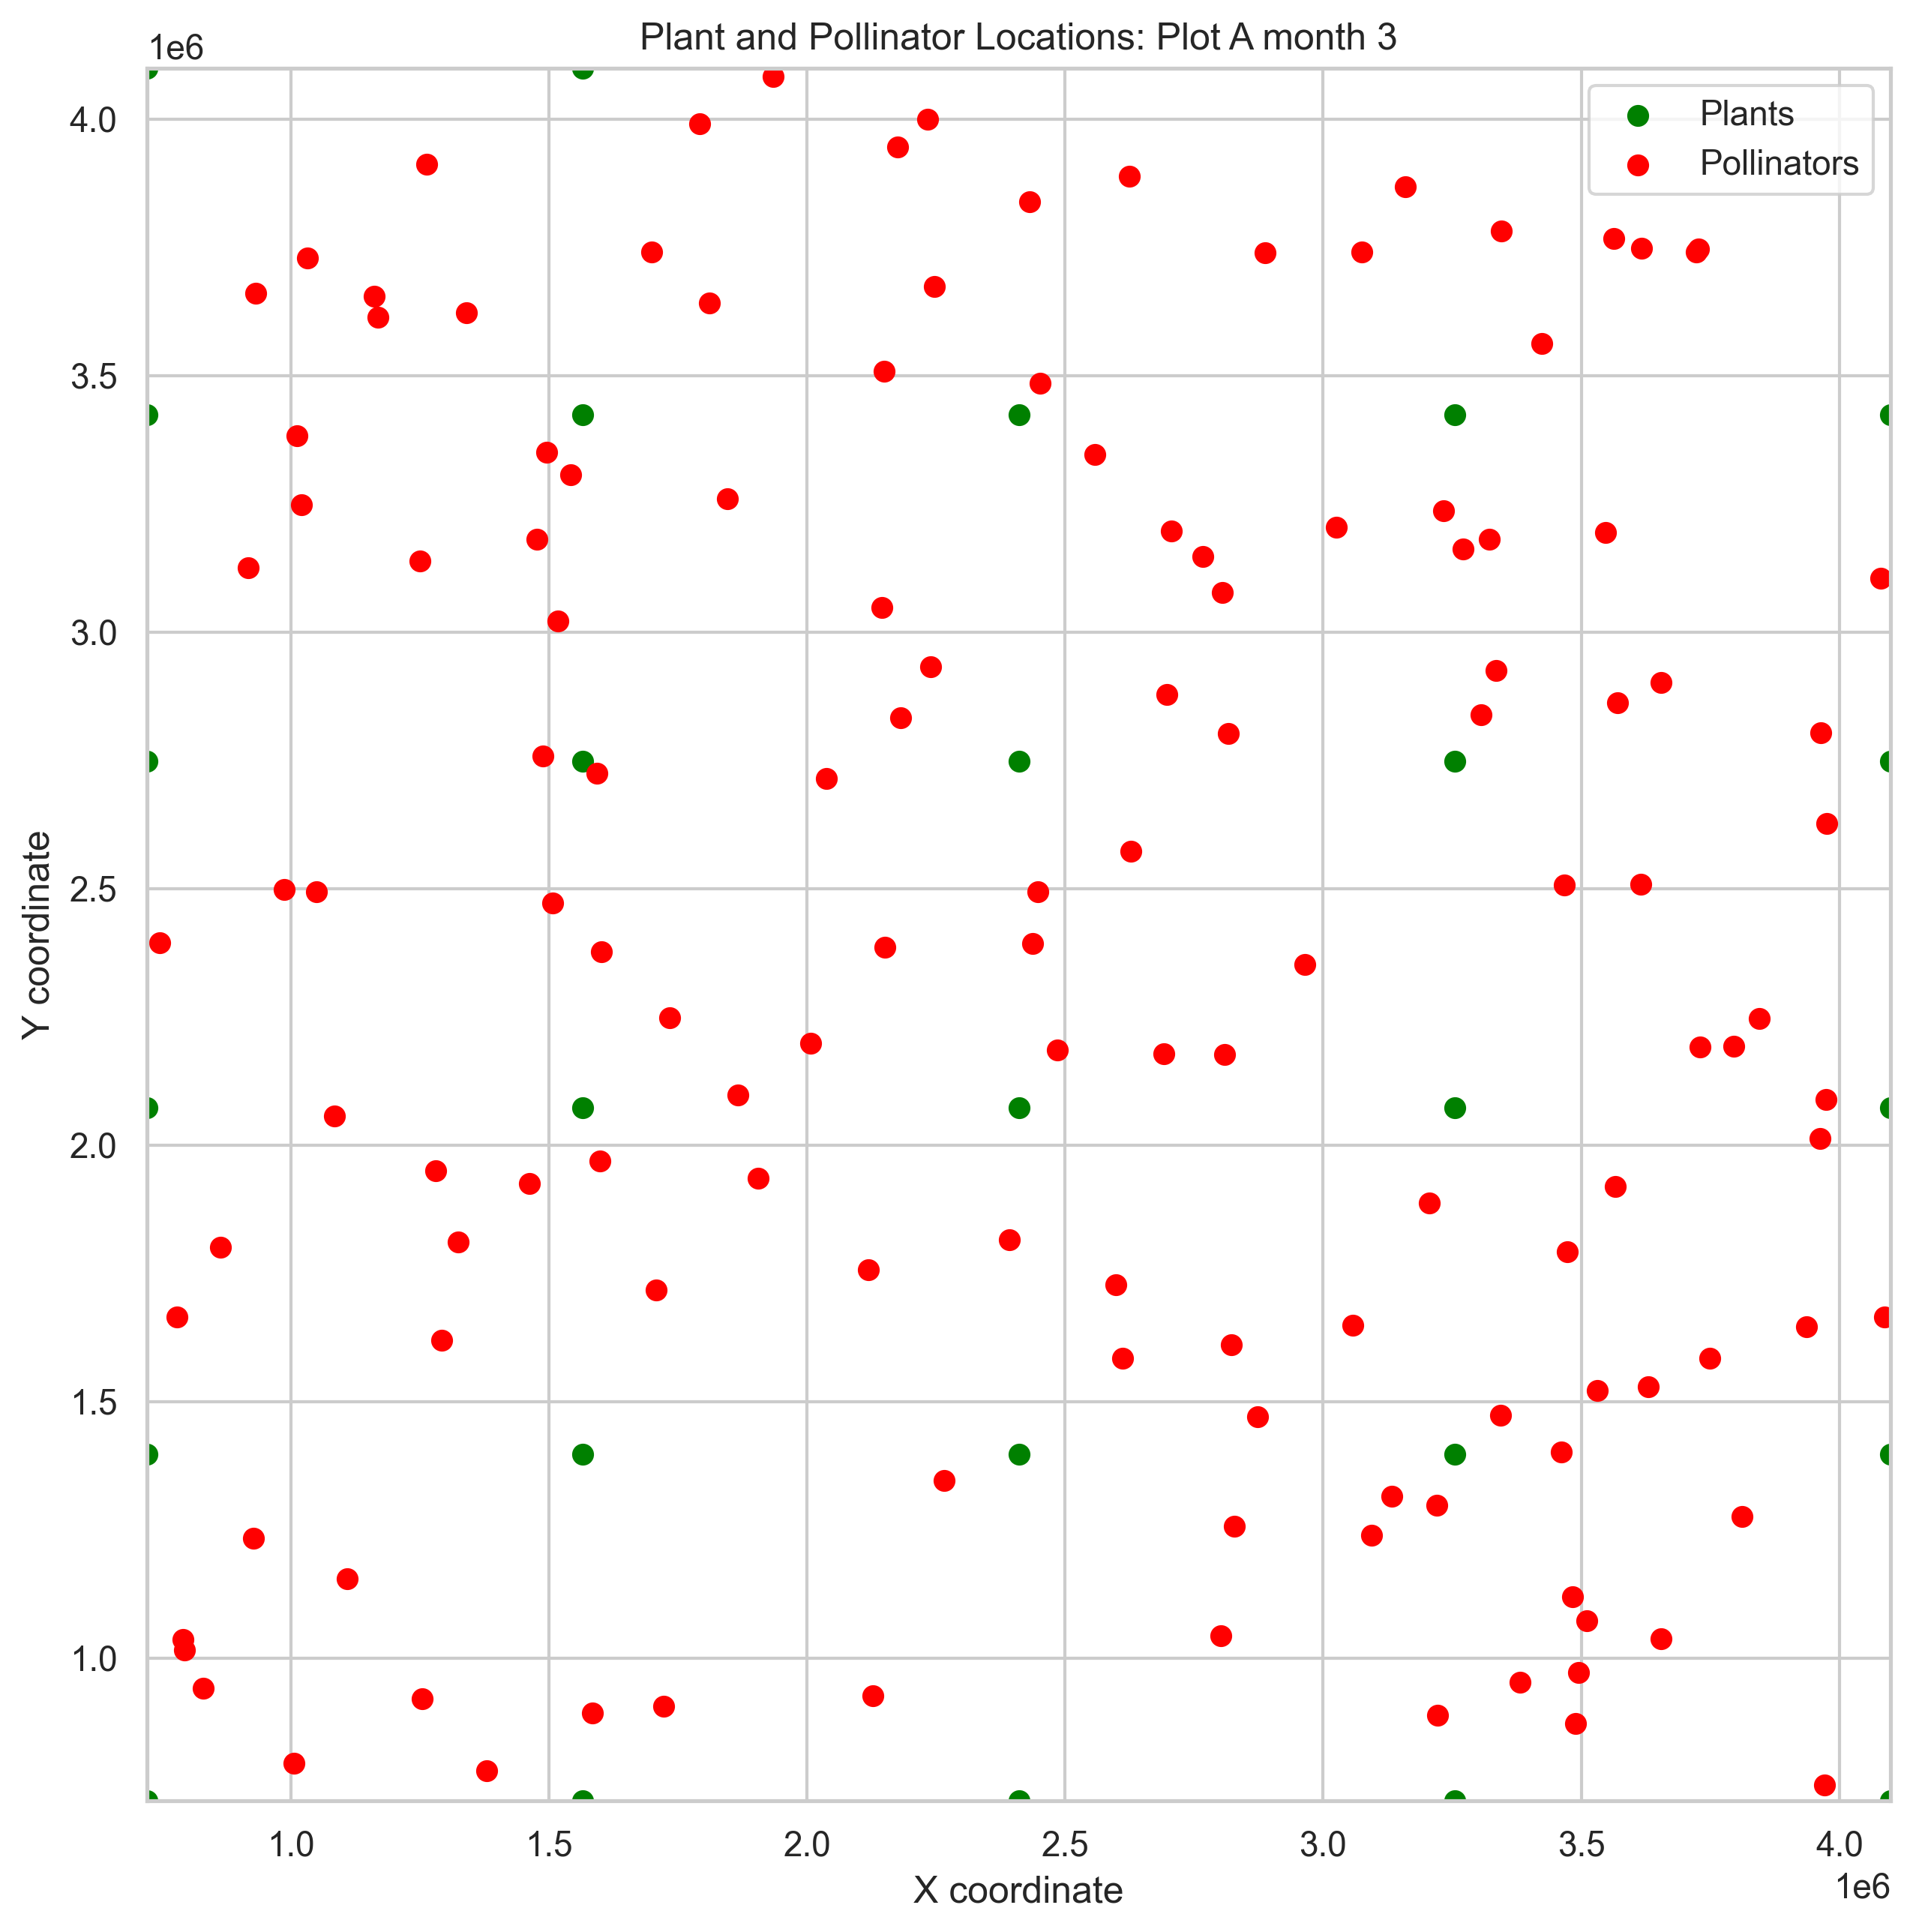

In [23]:
# 1. Visualize initial agent positions
ax1 = plot_agents(envp_regular, envpol, selected_plot, slice_index, xmin, xmax, ymin, ymax, save=False)


## Bayesian analysis

In [24]:
import glob
from netbayesabm.abc_module.metrics import compute_metrics, top_metric, resume_error, plot_degree_comp

# Reading the file
#file_pattern = 'Output_analysis/*random_deg_pol_randomproof.csv'
file_pattern = 'Output_analysis/*species_deg_pol_model2.csv'
#file_pattern = 'Output_analysis/A*species_deg_pol_model2.csv'
#file_pattern = 'Output_analysis/*regular_deg_pol.csv'
#file_pattern = 'Output_analysis/*XY_deg_pol.csv'
#file_pattern = 'Output_analysis/*random_deg_pol.csv'


In [25]:
# Find all files that match the pattern
file_list = glob.glob(file_pattern)
print(file_list)

['Output_analysis/A3_nd100__gamma_s2_5_sc2_1_species_deg_pol_model2.csv']


Output_analysis/A3_nd100__gamma_s2_5_sc2_1_species_deg_pol_model2.csv


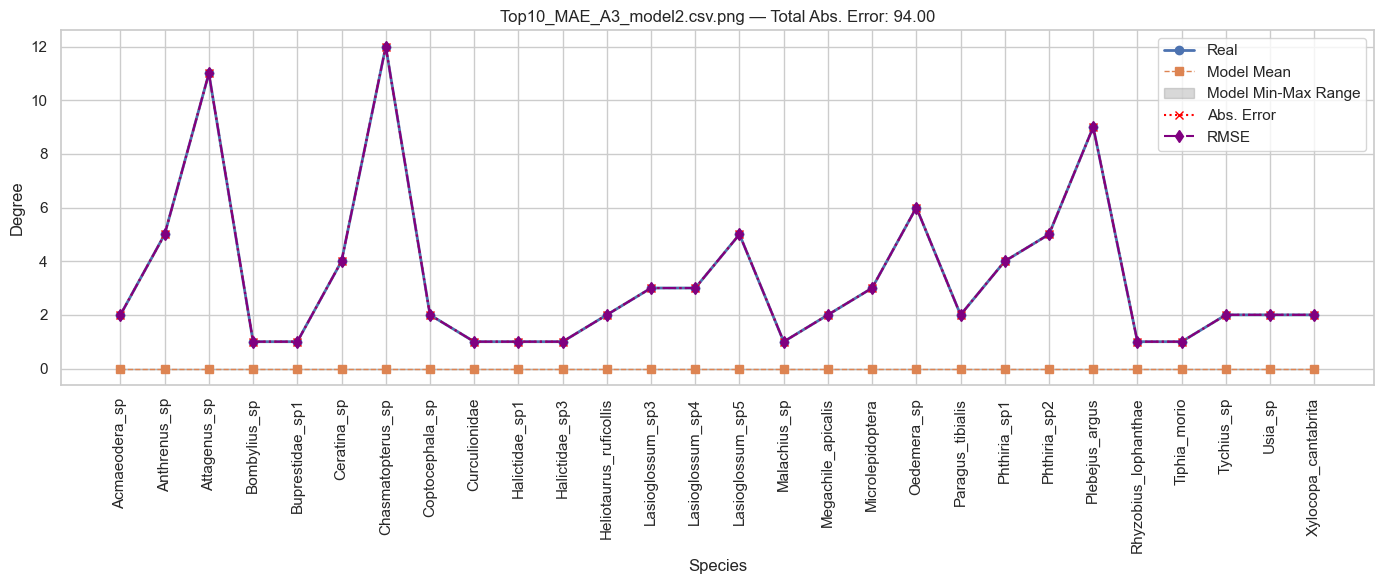

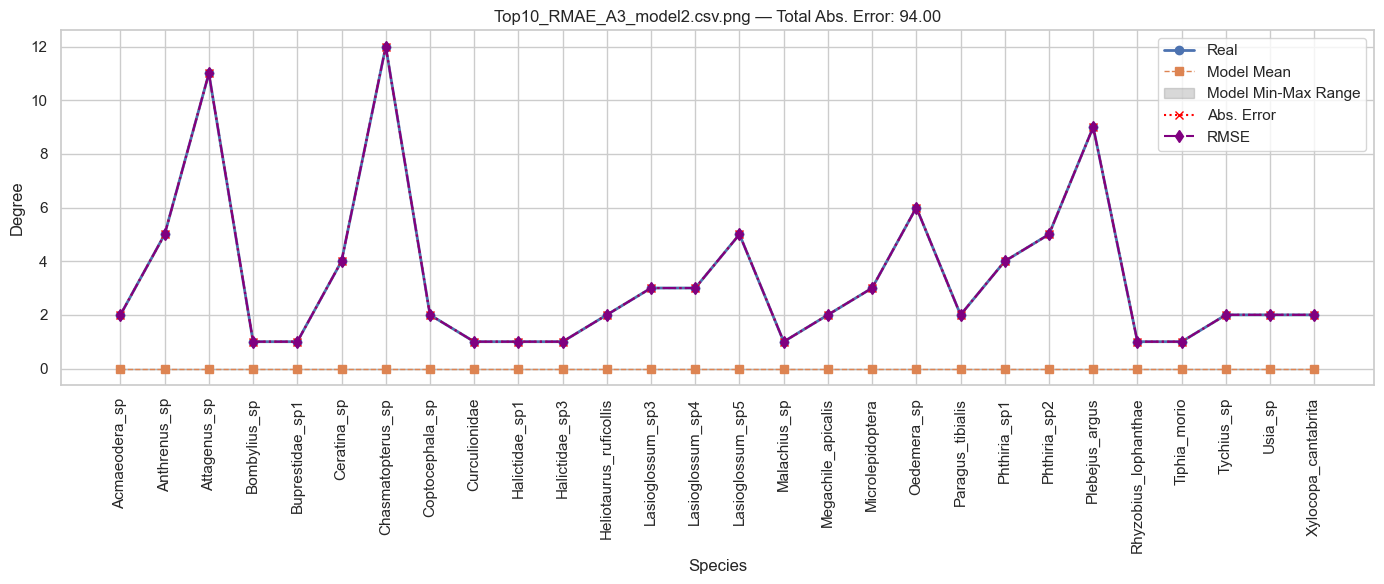

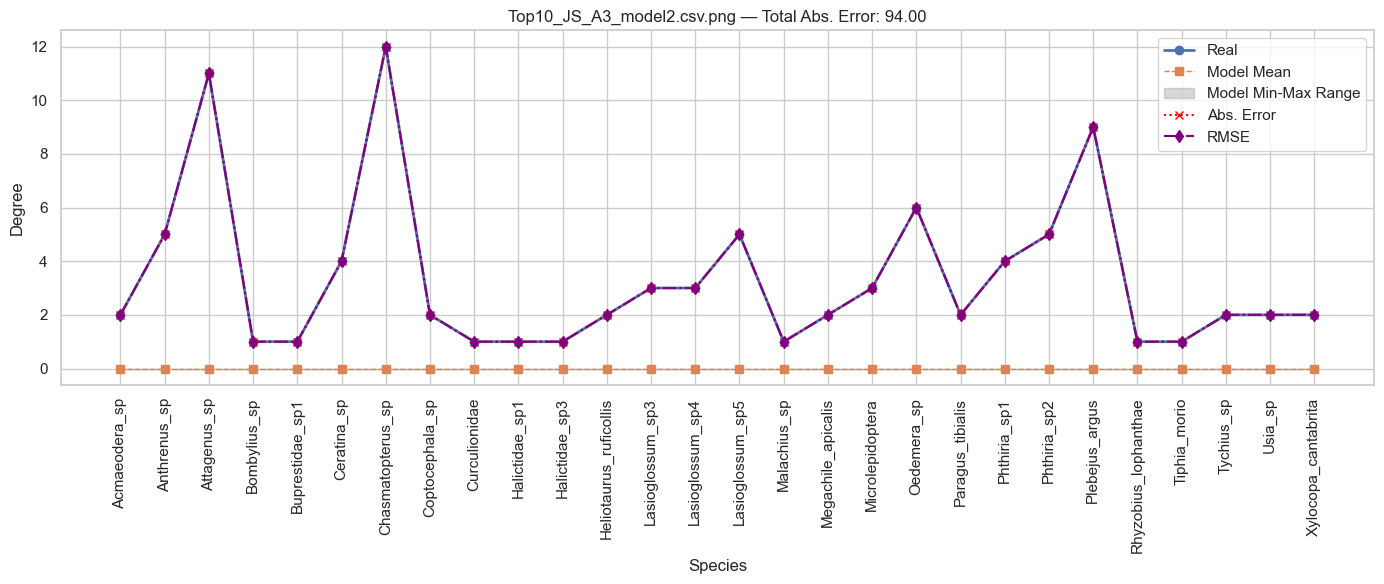

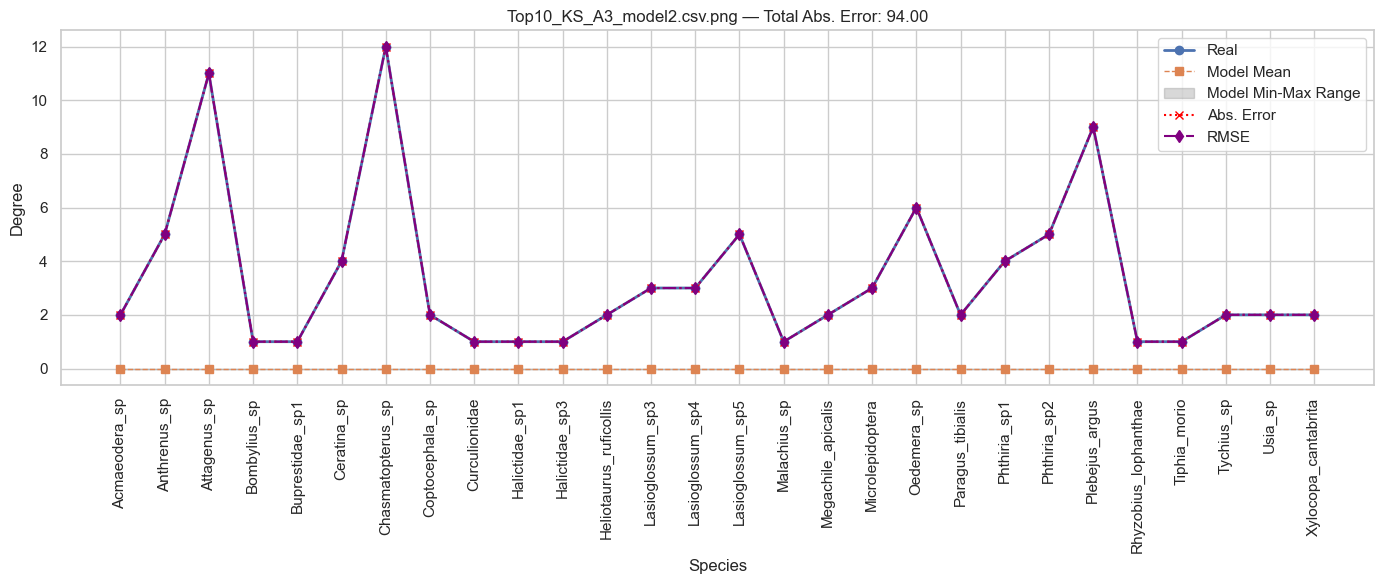

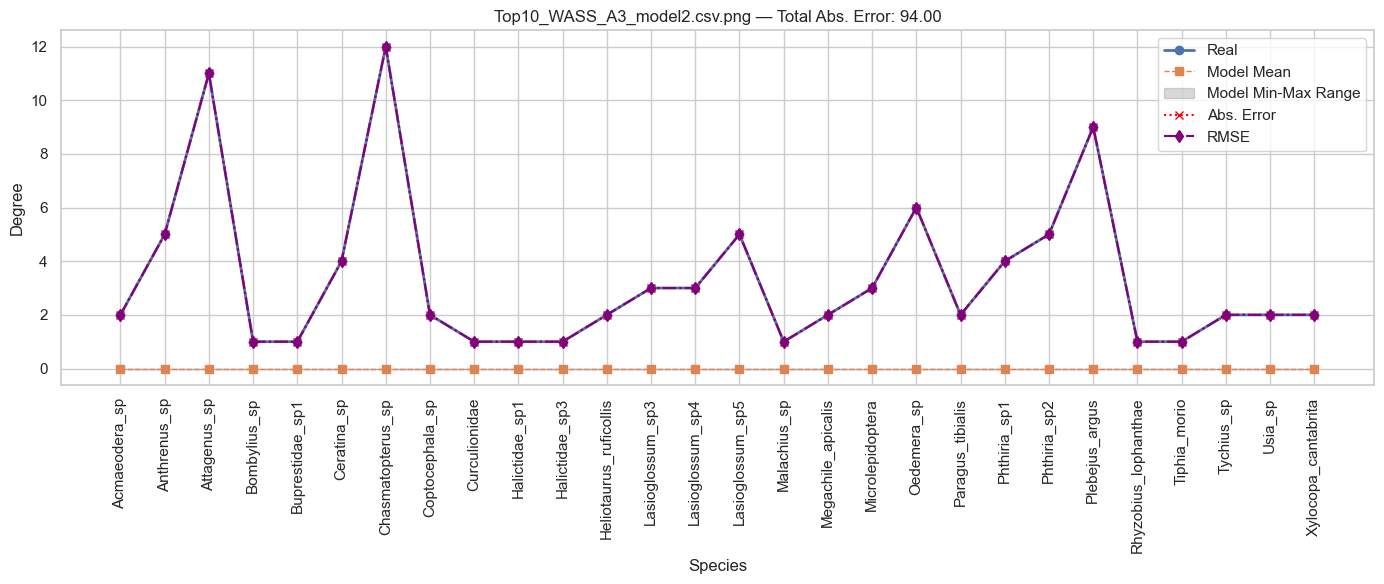

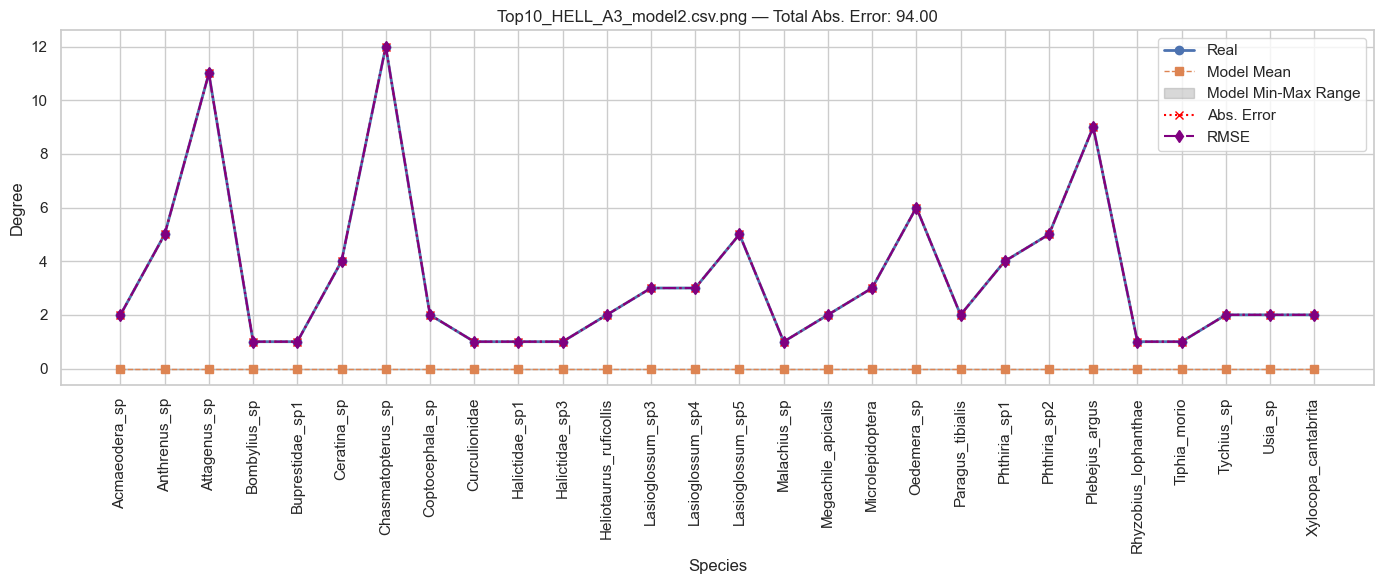

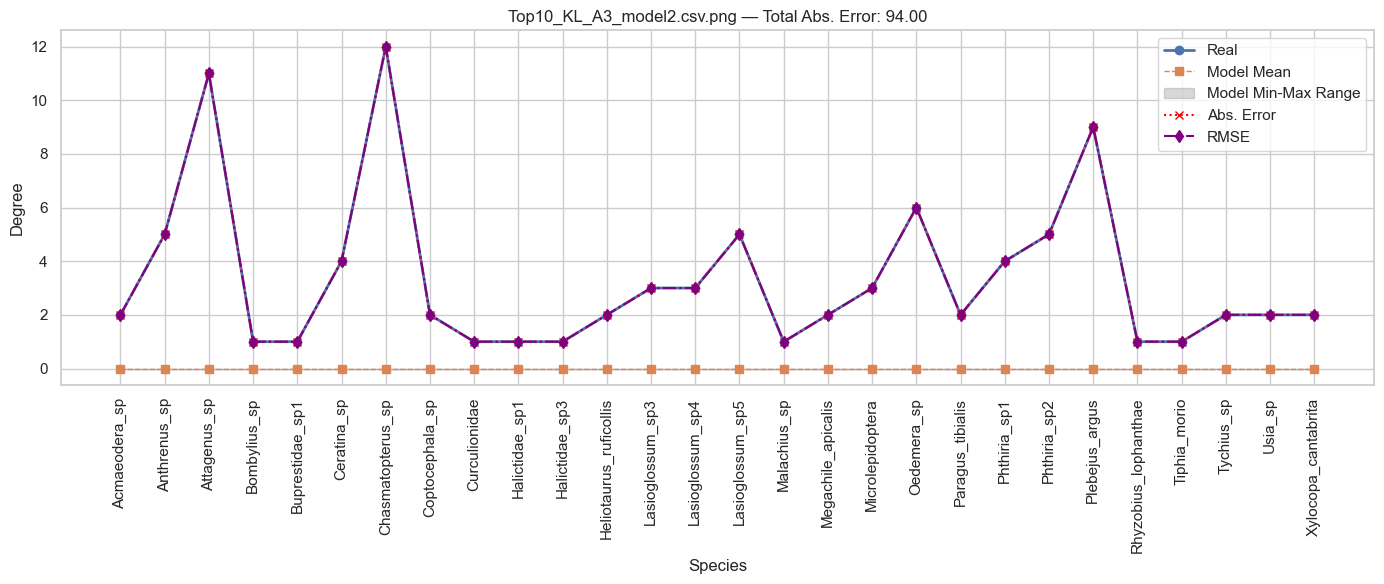

In [26]:

abs_errors = []  # list to save errors

for file_name in file_list:
    print(file_name)
    plot_month= file_name.split('/')[-1]
    pm = plot_month.split('_')[0]
    model = plot_month.split('_')[-1]
    data = pd.read_csv(file_name)
    metrics_df = compute_metrics(data)

    metrics = ["JS_divergence", "KS_distance", "Wasserstein_distance", 
           "Hellinger_distance", "Relative_MAE", "Absolute_MAE","KL_divergence"]
    
    top_dfs = {metric: top_metric(metrics_df, metric, top_fraction=0.1) for metric in metrics}


    # Diccionario que mapea métricas a etiquetas personalizadas para el plot
    metric_labels = {
        'Absolute_MAE': 'MAE',
        'Relative_MAE': 'RMAE',
        'JS_divergence': 'JS',
        'KS_distance': 'KS',
        'Wasserstein_distance': 'WASS',
        'Hellinger_distance': 'HELL',
        'KL_divergence': 'KL'  
    }
   

    for metric, label in metric_labels.items():
        if metric in top_dfs:
            name = label + '_'+ pm + '_' + model
            top_iterations = top_dfs[metric].iteration.values
            filtered_data = data[data['iteration'].isin(top_iterations)].copy()
            summary = resume_error(filtered_data)
            summary['metric'] = label
            summary['plot'] = name
            abs_errors.append(summary)
            # Opcional: generar gráfica
            plot_degree_comp(filtered_data, name)
            plt.savefig(f"{name}.png", dpi=300)
            #total_error = plot_degree_comp(filtered_data, name)
            #abs_errors.append({'metric': label, 'plot': name, 'total_abs_error': summary})
            #plt.savefig(f"{name}.png", dpi=300)



In [27]:
abs_errors_path = os.path.join(output_dir, f'abserrors_zscore_{model}')

df_abs_errors = pd.concat(abs_errors, ignore_index=True)
df_abs_errors.to_csv(abs_errors_path )
